In [ ]:
import os, re, magic, shutil
from glob import glob
import time, datetime
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import shutil
import warnings
import joblib

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch, gc
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
import torchvision
from torchvision import transforms

import sklearn
#from skimage import io
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.ndimage import zoom

import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

import wandb

In [6]:
path1 = '../Data/car_dataset/HY_현대/'
path2 = '../Data/car_dataset/KI_기아/'
path3 = '../Data/car_dataset/GE_제네시스/'
img_names = []
img_labels = []

for folder, subfolders, filenames in os.walk(path1):
    for img in filenames:
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:15])

for folder, subfolders, filenames in os.walk(path2):
    for img in filenames:
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:15])
        
for folder, subfolders, filenames in os.walk(path3):
    for img in filenames:
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:15])
        
        
print('Images: ',len(img_names))
print("Image_labels:", len(img_labels))

Images:  180588
Image_labels: 180588


In [9]:
#path = '../Data/car_dataset_sample/'
path = '../Data/car_dataset/'
#path = '../../disk/data/car_dataset/'
img_names = []
img_labels = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:18])

print('Images: ',len(img_names))
print("Image_labels:", len(img_labels))

Images:  290400
Image_labels: 290400


In [7]:
from sklearn.preprocessing import LabelEncoder


trn_df = pd.DataFrame(img_names, columns=['image_id'])
trn_df['dir'] = trn_df['image_id'].apply(lambda x: os.path.dirname(x))
trn_df['image_id'] = trn_df['image_id'].apply(lambda x: os.path.basename(x))
#trn_df['label'] = img_labels

label_value = []
for i, di in enumerate(trn_df['dir']):
    dir_l = di[23:-7].split('_')
    dir_v = dir_l[0][:-3] + dir_l[1]
    label_value.append(dir_v)

trn_df['label'] = label_value
train = trn_df
train

,image_id,dir,label
0,C_211206_HY_025_18_BL_A_P_01_054.jpg,../Data/car_dataset/HY_현대/025_i30/2018_파랑_트림A,현대/i30/2018
1,C_211206_HY_025_18_BL_A_P_01_048.jpg,../Data/car_dataset/HY_현대/025_i30/2018_파랑_트림A,현대/i30/2018
2,C_211206_HY_025_18_BL_A_T_02_005.jpg,../Data/car_dataset/HY_현대/025_i30/2018_파랑_트림A,현대/i30/2018
3,C_211206_HY_025_18_BL_A_P_01_025.jpg,../Data/car_dataset/HY_현대/025_i30/2018_파랑_트림A,현대/i30/2018
4,C_211206_HY_025_18_BL_A_T_03_001.jpg,../Data/car_dataset/HY_현대/025_i30/2018_파랑_트림A,현대/i30/2018
...,...,...,...
180583,C_211014_GE_018_20_BL_A_T_03_014.jpg,../Data/car_dataset/GE_제네시스/018_G70/2020_파랑_트림A,제네시스/G70/2020
180584,C_211014_GE_018_20_BL_A_T_03_009.jpg,../Data/car_dataset/GE_제네시스/018_G70/2020_파랑_트림A,제네시스/G70/2020
180585,C_211014_GE_018_20_BL_A_P_01_062.jpg,../Data/car_dataset/GE_제네시스/018_G70/2020_파랑_트림A,제네시스/G70/2020
180586,C_211014_GE_018_20_BL_A_P_01_016.jpg,../Data/car_dataset/GE_제네시스/018_G70/2020_파랑_트림A,제네시스/G70/2020


In [5]:
first = le.inverse_transform([100])
first

array(['닛산/알티마/2018'], dtype='<U18')

In [4]:
train['label'].value_counts()

현대/코나/2018      2755
기아/모닝/2017      2721
기아/K3/2019      2563
기아/스포티지/2018    2471
기아/쏘렌토/2017     2368
                ... 
기아/쏘울/2019       184
현대/아이오닉/2021     182
기아/셀토스/2018       95
현대/벨로스터/2021      95
현대/벨로스터/2017      95
Name: label, Length: 142, dtype: int64

In [12]:
train['label'].value_counts().loc[lambda x : x > 900]

현대/코나/2018       2755
기아/모닝/2017       2721
기아/K3/2019       2563
기아/스포티지/2018     2471
제네시스/G80/2018    2431
                 ... 
현대/코나/2020        940
기아/니로/2018        940
현대/스타렉스/2020      937
현대/팰리세이드/2020     935
기아/니로/2019        923
Name: label, Length: 95, dtype: int64

In [13]:
low_data = train['label'].value_counts().loc[lambda x : x < 900].index

low_data = low_data.sort_values()
low_data

# for i, label in enumerate(train['label']):
#     #print(label)
#     if any(j in label for j in low_data) :
#         train.drop(i)
# train['label'].value_counts()

Index(['기아/K5/2021', '기아/K7/2021', '기아/K9/2017', '기아/K9/2018', '기아/니로/2021',
       '기아/레이/2021', '기아/모하비/2019', '기아/모하비/2020', '기아/모하비/2021',
       '기아/봉고3/2018', '기아/봉고3/2019', '기아/봉고3/2020', '기아/봉고3/2021',
       '기아/셀토스/2018', '기아/셀토스/2019', '기아/셀토스/2020', '기아/스토닉/2017',
       '기아/스토닉/2020', '기아/스토닉/2021', '기아/스팅어/2017', '기아/스팅어/2021',
       '기아/스포티지/2020', '기아/스포티지/2021', '기아/쏘울/2017', '기아/쏘울/2018',
       '기아/쏘울/2019', '기아/카니발/2021', '제네시스/EQ900/2019', '제네시스/G70/2020',
       '제네시스/G70/2021', '제네시스/G80/2020', '제네시스/G90/2020', '제네시스/G90/2021',
       '제네시스/GV80/2020', '제네시스/GV80/2021', '현대/i30/2017', '현대/i30/2018',
       '현대/i30/2019', '현대/넥쏘/2020', '현대/맥스크루즈/2017', '현대/맥스크루즈/2018',
       '현대/베뉴/2019', '현대/베뉴/2021', '현대/벨로스터/2017', '현대/벨로스터/2018',
       '현대/벨로스터/2019', '현대/벨로스터/2020', '현대/벨로스터/2021', '현대/스타렉스/2021',
       '현대/싼타페/2021', '현대/아이오닉/2017', '현대/아이오닉/2018', '현대/아이오닉/2019',
       '현대/아이오닉/2020', '현대/아이오닉/2021', '현대/엑센트/2017', '현대/엑센트/2018',
       '현대/엑센트/2019', 

In [14]:
# 해당 라벨과 일치하는 인덱스(열) 삭제
for i in range(len(low_data)):
    idx = train[train['label'] == low_data[i]].index
    train.drop(idx, inplace=True)
train.reset_index(inplace=True, drop=True)
train
# idx

,image_id,dir,label
0,C_210811_HY_053_20_WH_A_P_01_058.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,현대/베뉴/2020
1,C_211206_HY_053_20_WH_A_P_01_014.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,현대/베뉴/2020
2,C_211206_HY_053_20_WH_A_T_02_012.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,현대/베뉴/2020
3,C_210811_HY_053_20_WH_A_P_01_024.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,현대/베뉴/2020
4,C_211206_HY_053_20_WH_A_T_02_011.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,현대/베뉴/2020
...,...,...,...
148794,C_211129_GE_018_18_WH_C_P_01_034.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,제네시스/G70/2018
148795,C_211129_GE_018_18_WH_C_P_01_026.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,제네시스/G70/2018
148796,C_211129_GE_018_18_WH_C_P_01_025.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,제네시스/G70/2018
148797,C_211129_GE_018_18_WH_C_P_01_023.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,제네시스/G70/2018


In [15]:
train['label'].value_counts()

현대/코나/2018       2755
기아/모닝/2017       2721
기아/K3/2019       2563
기아/스포티지/2018     2471
제네시스/G80/2018    2431
                 ... 
기아/니로/2018        940
현대/코나/2020        940
현대/스타렉스/2020      937
현대/팰리세이드/2020     935
기아/니로/2019        923
Name: label, Length: 95, dtype: int64

In [7]:
print(len(train.label))

206646


In [7]:
train.label.nunique()

134

In [16]:
label_value = train['label'].values
label_value

array(['현대/베뉴/2020', '현대/베뉴/2020', '현대/베뉴/2020', ..., '제네시스/G70/2018',
       '제네시스/G70/2018', '제네시스/G70/2018'], dtype=object)

In [17]:
# 라벨인코더 선언 및 Fitting
le = LabelEncoder()
le.fit(label_value)

# 인코딩한 데이터로 변환
le_encoded = le.transform(label_value)

#결과물을 확인하면 array 형태로 나옵니다.
# 아래는 라벨 인코딩으로 만들어낸 데이터를 데이터 프레임으로 만들어주는 코드입니다.
new_cat = pd.DataFrame(le_encoded, columns = ['result'])
train['label'] = new_cat
train

,image_id,dir,label
0,C_210811_HY_053_20_WH_A_P_01_058.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,65
1,C_211206_HY_053_20_WH_A_P_01_014.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,65
2,C_211206_HY_053_20_WH_A_T_02_012.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,65
3,C_210811_HY_053_20_WH_A_P_01_024.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,65
4,C_211206_HY_053_20_WH_A_T_02_011.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,65
...,...,...,...
148794,C_211129_GE_018_18_WH_C_P_01_034.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,53
148795,C_211129_GE_018_18_WH_C_P_01_026.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,53
148796,C_211129_GE_018_18_WH_C_P_01_025.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,53
148797,C_211129_GE_018_18_WH_C_P_01_023.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,53


In [18]:
le.classes_

array(['기아/K3/2017', '기아/K3/2018', '기아/K3/2019', '기아/K3/2020',
       '기아/K3/2021', '기아/K5/2017', '기아/K5/2018', '기아/K5/2019',
       '기아/K5/2020', '기아/K7/2017', '기아/K7/2018', '기아/K7/2019',
       '기아/K7/2020', '기아/K9/2019', '기아/K9/2020', '기아/K9/2021',
       '기아/니로/2017', '기아/니로/2018', '기아/니로/2019', '기아/니로/2020',
       '기아/레이/2017', '기아/레이/2018', '기아/레이/2019', '기아/레이/2020',
       '기아/모닝/2017', '기아/모닝/2018', '기아/모닝/2019', '기아/모닝/2020',
       '기아/모닝/2021', '기아/모하비/2017', '기아/모하비/2018', '기아/봉고3/2017',
       '기아/셀토스/2021', '기아/스토닉/2018', '기아/스토닉/2019', '기아/스팅어/2018',
       '기아/스팅어/2019', '기아/스팅어/2020', '기아/스포티지/2017', '기아/스포티지/2018',
       '기아/스포티지/2019', '기아/쏘렌토/2017', '기아/쏘렌토/2018', '기아/쏘렌토/2019',
       '기아/쏘렌토/2020', '기아/쏘렌토/2021', '기아/카니발/2017', '기아/카니발/2018',
       '기아/카니발/2019', '기아/카니발/2020', '제네시스/EQ900/2017', '제네시스/EQ900/2018',
       '제네시스/G70/2017', '제네시스/G70/2018', '제네시스/G70/2019', '제네시스/G80/2017',
       '제네시스/G80/2018', '제네시스/G80/2019', '제네시스/G80/2021', '제네시스/G90/2019

In [6]:
dist.destroy_process_group()

NameError: name 'dist' is not defined

In [10]:
project_name = 'preprocessed_ef_ns03_HK01'
user = 'hojunking'
run_name = 'preprocessed_ef_ns_03_HK01'

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hojunking. Use `wandb login --relogin` to force relogin


Training start with epoch 40 



/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/apex/__init__.py:68: DeprecatedFeatureWarning: apex.parallel.DistributedDataParallel is deprecated and will be removed by the end of February 2023.
  warnings.warn(msg, DeprecatedFeatureWarning)
epoch 0 loss: 1.3057: 100%|█████████████████| 6406/6406 [25:39<00:00,  4.16it/s]

train accuracy = 0.37222
[[ 969  207   76 ...    1    1    5]
 [ 337  485   67 ...    2    1   11]
 [ 122   97  476 ...    2    0    9]
 ...
 [   4    1    0 ...  911  331   12]
 [   9    0    0 ...  525  670   15]
 [   1    0    2 ...    2    3 1690]]



epoch 0 loss: 1.2000: 100%|█████████████████| 1750/1750 [03:00<00:00,  9.68it/s]


validation accuracy = 0.53429
[[196  21  21 ...   0   1   0]
 [ 66 101   9 ...   2   0   0]
 [  7  45 203 ...   0   0   0]
 ...
 [  0   0   0 ...  85  10   0]
 [  0   0   0 ...  49  79   0]
 [  0   0   0 ...   0   0 191]]


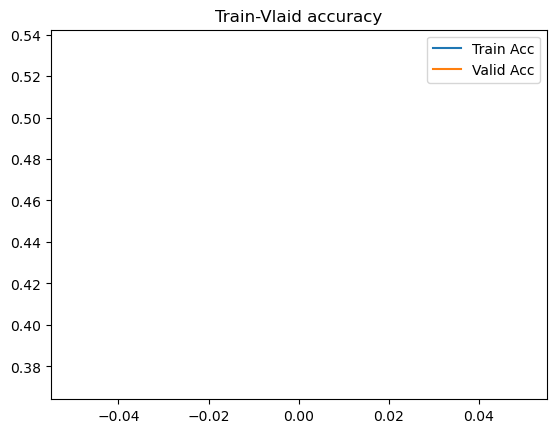

epoch 1 loss: 0.9181: 100%|█████████████████| 6406/6406 [24:52<00:00,  4.29it/s]

train accuracy = 0.61379
[[1419  270  116 ...    0    0    2]
 [ 342 1129  102 ...    0    0    0]
 [  67  170  957 ...    0    0    0]
 ...
 [   0    0    0 ... 1395  319    0]
 [   1    0    0 ...  482 1245    1]
 [   0    0    0 ...    0    0 2054]]



epoch 1 loss: 0.9394: 100%|█████████████████| 1750/1750 [02:56<00:00,  9.92it/s]


validation accuracy = 0.63044
[[245  21  11 ...   0   0   0]
 [ 52 140   6 ...   2   0   0]
 [ 14  36 260 ...   0   0   0]
 ...
 [  0   0   0 ... 131  22   0]
 [  0   0   0 ...  32 149   0]
 [  0   0   0 ...   0   0 210]]


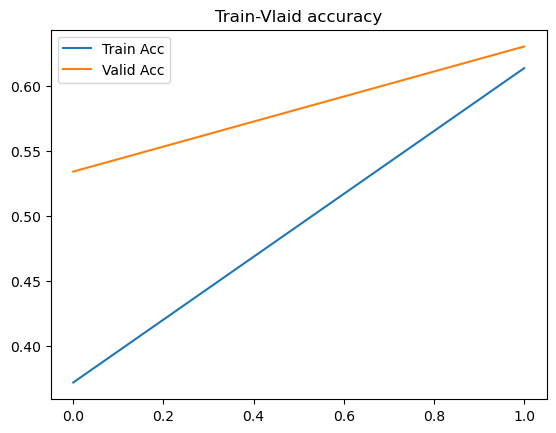

epoch 2 loss: 0.6745: 100%|█████████████████| 6406/6406 [24:52<00:00,  4.29it/s]

train accuracy = 0.71998
[[1683  185   78 ...    0    1    2]
 [ 238 1516  108 ...    0    0    0]
 [  48  160 1272 ...    0    0    1]
 ...
 [   0    0    0 ... 1702  222    0]
 [   0    0    0 ...  341 1549    1]
 [   0    0    0 ...    0    0 2122]]



epoch 2 loss: 0.8075: 100%|█████████████████| 1750/1750 [02:56<00:00,  9.90it/s]


validation accuracy = 0.69398
[[266  12  11 ...   0   0   0]
 [ 40 189   3 ...   1   1   0]
 [ 10  64 274 ...   0   0   0]
 ...
 [  0   0   0 ... 138  21   0]
 [  0   0   0 ...  25 177   0]
 [  0   0   0 ...   0   0 218]]


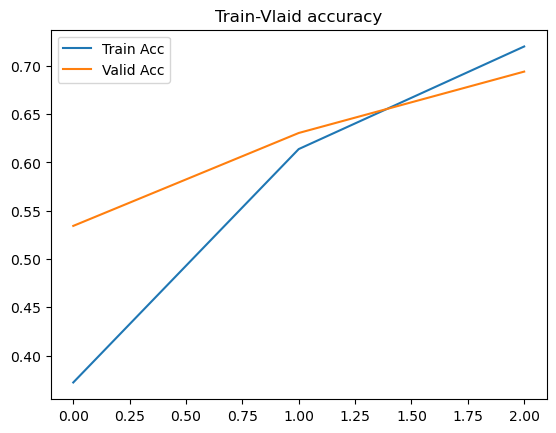

epoch 3 loss: 0.5193: 100%|█████████████████| 6406/6406 [24:57<00:00,  4.28it/s]

train accuracy = 0.79057
[[1888  116   51 ...    0    0    0]
 [ 158 1741   86 ...    0    0    0]
 [  41  161 1460 ...    1    0    0]
 ...
 [   0    0    0 ... 1881  153    0]
 [   0    0    0 ...  228 1760    0]
 [   0    0    1 ...    0    0 2141]]



epoch 3 loss: 0.7303: 100%|█████████████████| 1750/1750 [02:56<00:00,  9.90it/s]


validation accuracy = 0.72639
[[246  21  13 ...   0   0   1]
 [ 15 199  15 ...   0   2   0]
 [  2  44 333 ...   0   0   0]
 ...
 [  0   0   0 ... 141  34   0]
 [  0   0   0 ...  18 202   0]
 [  0   0   0 ...   0   0 216]]


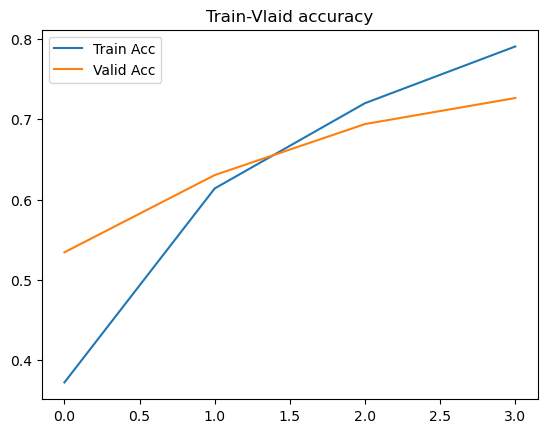

epoch 4 loss: 0.4173: 100%|█████████████████| 6406/6406 [24:56<00:00,  4.28it/s]

train accuracy = 0.83572
[[1969   60   47 ...    0    0    3]
 [  78 1890   90 ...    0    0    0]
 [  45  152 1635 ...    0    0    0]
 ...
 [   0    0    0 ... 1974  122    0]
 [   0    0    1 ...  155 1903    0]
 [   1    0    0 ...    0    0 2154]]



epoch 4 loss: 0.6447: 100%|█████████████████| 1750/1750 [02:57<00:00,  9.85it/s]


validation accuracy = 0.76791
[[267  19   4 ...   0   0   0]
 [ 17 217   6 ...   0   2   0]
 [  8  47 359 ...   0   0   0]
 ...
 [  0   0   0 ... 164  13   0]
 [  0   0   0 ...  25 191   0]
 [  0   0   0 ...   0   0 218]]


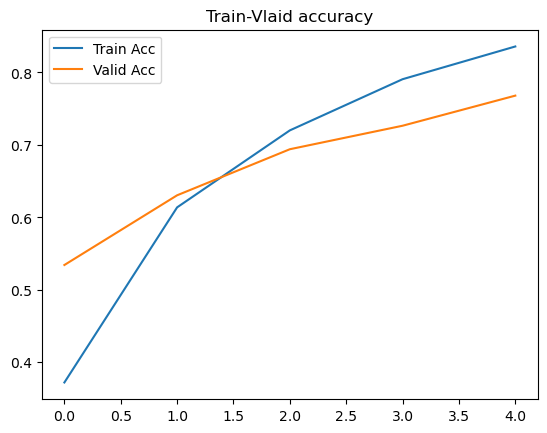

epoch 5 loss: 0.3445: 100%|█████████████████| 6406/6406 [24:56<00:00,  4.28it/s]

train accuracy = 0.86762
[[2026   58   36 ...    0    0    0]
 [  61 1948   73 ...    0    0    0]
 [  30  128 1701 ...    0    0    0]
 ...
 [   0    0    0 ... 2052   75    0]
 [   0    0    0 ...   89 1998    0]
 [   0    0    0 ...    0    0 2163]]



epoch 5 loss: 0.6140: 100%|█████████████████| 1750/1750 [02:58<00:00,  9.82it/s]


validation accuracy = 0.78885
[[272  10   5 ...   0   0   0]
 [ 21 226   2 ...   0   2   0]
 [ 10  64 347 ...   0   0   0]
 ...
 [  0   1   0 ... 148  20   0]
 [  0   0   0 ...  11 201   0]
 [  0   0   0 ...   0   0 218]]


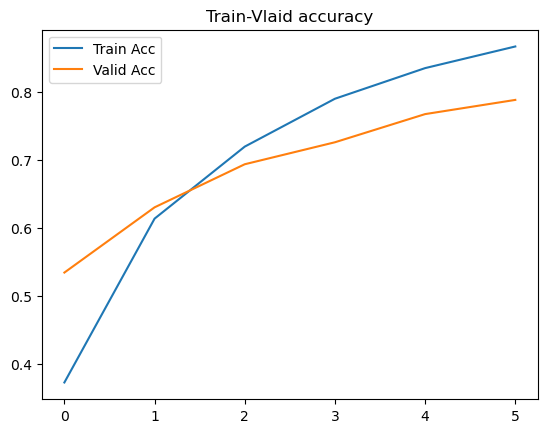

epoch 6 loss: 0.2758: 100%|█████████████████| 6406/6406 [24:59<00:00,  4.27it/s]

train accuracy = 0.89130
[[2075   37   28 ...    0    0    0]
 [  44 2002   84 ...    0    0    0]
 [  23  129 1775 ...    2    0    0]
 ...
 [   0    0    0 ... 2066   72    0]
 [   0    0    0 ...   72 2036    1]
 [   0    0    0 ...    0    0 2185]]



epoch 6 loss: 0.5909: 100%|█████████████████| 1750/1750 [02:58<00:00,  9.81it/s]


validation accuracy = 0.80375
[[282  10   1 ...   0   0   0]
 [  8 232   5 ...   0   2   0]
 [  7  53 345 ...   0   0   0]
 ...
 [  0   1   0 ... 174   5   0]
 [  0   0   0 ...  21 189   0]
 [  0   0   0 ...   0   0 217]]


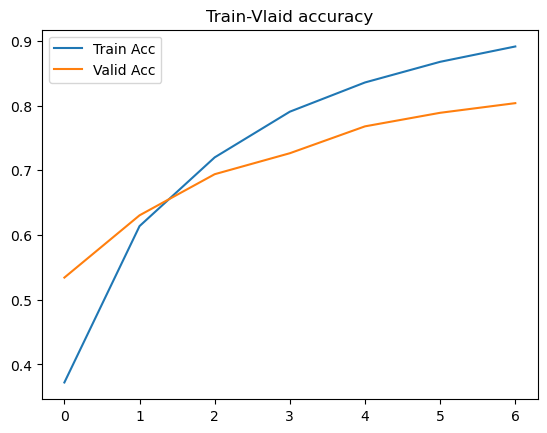

epoch 7 loss: 0.2397: 100%|█████████████████| 6406/6406 [24:59<00:00,  4.27it/s]

train accuracy = 0.90787
[[2076   40   18 ...    0    0    0]
 [  41 2021   69 ...    0    0    0]
 [  14  129 1814 ...    0    0    0]
 ...
 [   0    1    0 ... 2084   64    0]
 [   0    0    0 ...   79 2033    0]
 [   0    0    0 ...    1    0 2172]]



epoch 7 loss: 0.5923: 100%|█████████████████| 1750/1750 [02:58<00:00,  9.80it/s]


validation accuracy = 0.81065
[[270  13   4 ...   0   0   0]
 [ 14 224  13 ...   0   2   0]
 [  5  43 388 ...   0   0   0]
 ...
 [  0   0   0 ... 160  14   0]
 [  0   0   0 ...  13 200   0]
 [  0   0   0 ...   0   0 214]]


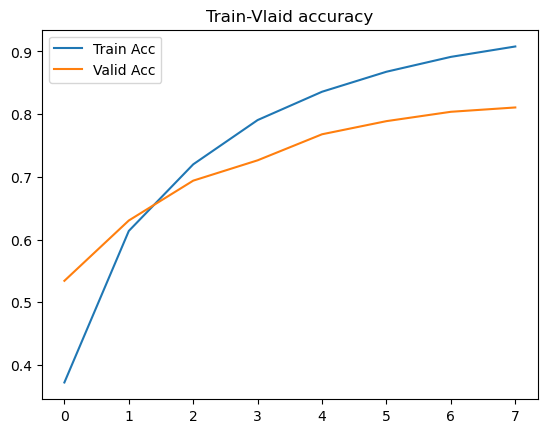

epoch 8 loss: 0.2154: 100%|█████████████████| 6406/6406 [25:03<00:00,  4.26it/s]

train accuracy = 0.92007
[[2104   30   16 ...    0    0    0]
 [  42 2047   62 ...    0    0    0]
 [  13  104 1866 ...    0    0    0]
 ...
 [   0    0    0 ... 2123   38    0]
 [   0    0    0 ...   45 2081    0]
 [   0    0    0 ...    0    0 2189]]



epoch 8 loss: 0.5667: 100%|█████████████████| 1750/1750 [02:57<00:00,  9.88it/s]


validation accuracy = 0.82258
[[275  14   4 ...   0   0   0]
 [ 13 229  12 ...   0   1   0]
 [  4  49 384 ...   0   0   0]
 ...
 [  0   0   0 ... 174   3   0]
 [  0   0   0 ...  17 198   0]
 [  0   0   0 ...   0   0 211]]


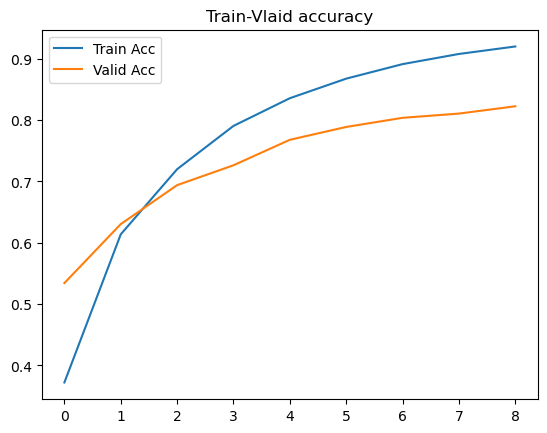

epoch 9 loss: 0.2015: 100%|█████████████████| 6406/6406 [24:56<00:00,  4.28it/s]

train accuracy = 0.92933
[[2097   25   21 ...    0    0    0]
 [  30 2048   61 ...    0    0    0]
 [  19  107 1876 ...    0    0    0]
 ...
 [   0    0    0 ... 2112   52    0]
 [   0    0    0 ...   53 2096    0]
 [   0    0    0 ...    0    0 2177]]



epoch 9 loss: 0.5926: 100%|█████████████████| 1750/1750 [02:58<00:00,  9.80it/s]


validation accuracy = 0.82516
[[283   6   4 ...   0   0   0]
 [ 12 215  15 ...   0   2   0]
 [  5  37 360 ...   0   0   0]
 ...
 [  0   0   0 ... 168   7   0]
 [  0   0   0 ...  21 196   0]
 [  0   0   0 ...   0   0 219]]


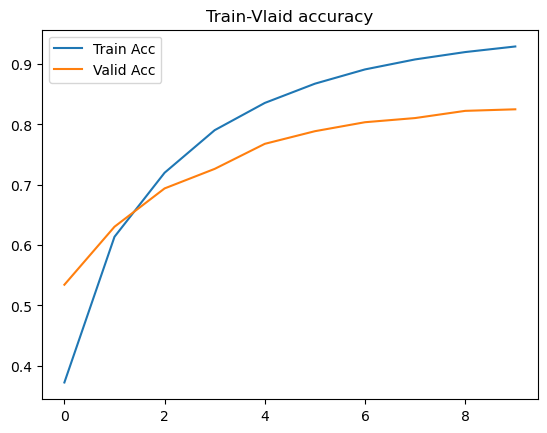

epoch 10 loss: 0.1654: 100%|████████████████| 6406/6406 [24:58<00:00,  4.27it/s]

train accuracy = 0.93791
[[2128   24   11 ...    0    0    1]
 [  31 2068   51 ...    0    0    1]
 [   9   84 1958 ...    0    0    0]
 ...
 [   0    0    0 ... 2141   29    0]
 [   0    0    1 ...   43 2113    0]
 [   0    0    0 ...    0    0 2177]]



epoch 10 loss: 0.5561: 100%|████████████████| 1750/1750 [02:57<00:00,  9.84it/s]


validation accuracy = 0.83541
[[274   8   1 ...   0   0   0]
 [  1 253   3 ...   0   2   0]
 [  3  69 370 ...   0   0   0]
 ...
 [  0   0   0 ... 164  13   0]
 [  0   0   0 ...  14 195   0]
 [  0   0   0 ...   0   0 216]]


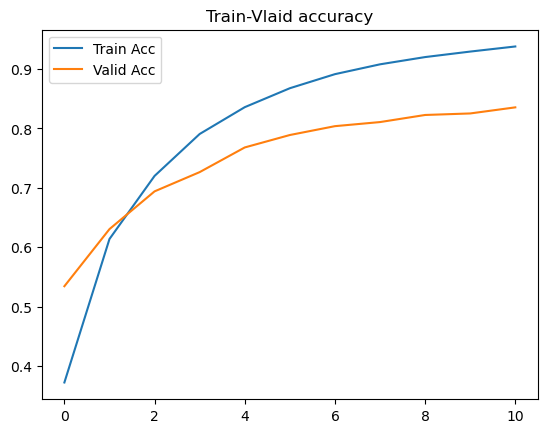

epoch 11 loss: 0.1648: 100%|████████████████| 6406/6406 [24:59<00:00,  4.27it/s]

train accuracy = 0.94354
[[2125   17   17 ...    0    0    0]
 [  15 2090   51 ...    0    0    0]
 [  18   78 1964 ...    0    0    0]
 ...
 [   0    0    0 ... 2148   23    0]
 [   0    0    0 ...   35 2120    0]
 [   1    1    0 ...    0    0 2185]]



epoch 11 loss: 0.5830: 100%|████████████████| 1750/1750 [03:00<00:00,  9.67it/s]


validation accuracy = 0.83334
[[277  12   3 ...   0   0   0]
 [ 11 233   8 ...   0   2   0]
 [  5  65 379 ...   0   0   0]
 ...
 [  0   0   0 ... 174   6   0]
 [  0   0   1 ...  19 192   0]
 [  0   0   0 ...   0   0 216]]


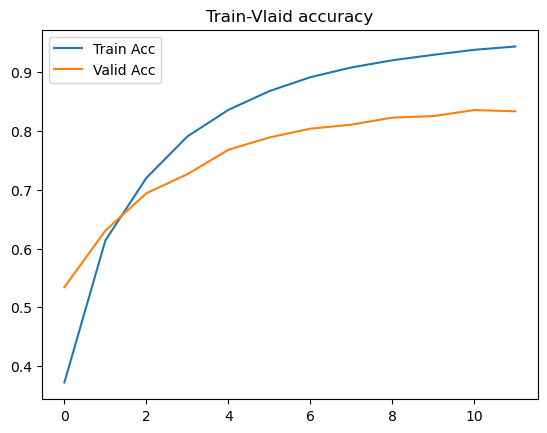

epoch 12 loss: 0.1519: 100%|████████████████| 6406/6406 [25:06<00:00,  4.25it/s]

train accuracy = 0.94975
[[2159   12    4 ...    0    0    0]
 [  17 2094   54 ...    0    0    0]
 [   3   76 1988 ...    0    0    0]
 ...
 [   0    0    0 ... 2145   27    0]
 [   0    0    0 ...   35 2130    0]
 [   1    0    1 ...    0    0 2186]]



epoch 12 loss: 0.5918: 100%|████████████████| 1750/1750 [02:58<00:00,  9.81it/s]


validation accuracy = 0.83259
[[278   9   3 ...   0   0   0]
 [  8 219  16 ...   0   2   0]
 [  3  38 383 ...   0   0   0]
 ...
 [  0   0   0 ... 168  11   0]
 [  0   0   0 ...  12 201   0]
 [  0   0   0 ...   0   0 218]]


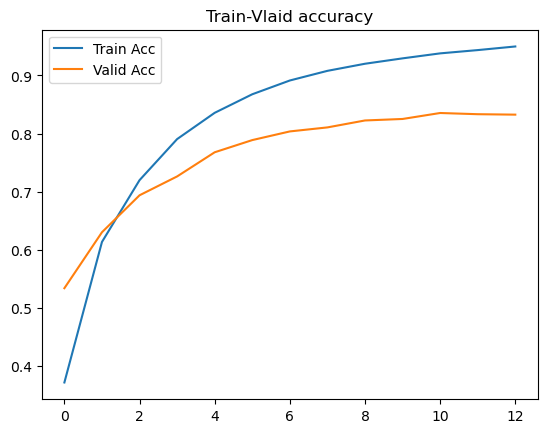

epoch 13 loss: 0.1293: 100%|████████████████| 6406/6406 [25:00<00:00,  4.27it/s]

train accuracy = 0.95420
[[2151   12    3 ...    0    0    0]
 [  14 2101   56 ...    0    0    0]
 [   6   81 1984 ...    0    0    0]
 ...
 [   0    0    0 ... 2154   25    0]
 [   0    0    0 ...   26 2143    0]
 [   1    0    0 ...    0    0 2192]]



epoch 13 loss: 0.5751: 100%|████████████████| 1750/1750 [02:59<00:00,  9.76it/s]


validation accuracy = 0.84102
[[252  27   6 ...   0   0   0]
 [  3 235  11 ...   0   2   0]
 [  5  44 380 ...   0   0   0]
 ...
 [  0   0   0 ... 163  12   0]
 [  0   0   0 ...   9 203   0]
 [  0   0   0 ...   0   0 219]]


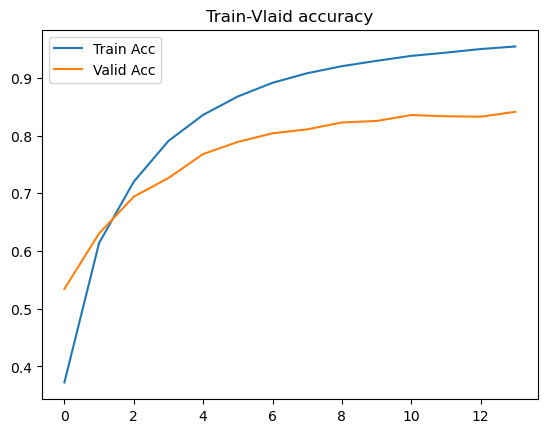

epoch 14 loss: 0.1310: 100%|████████████████| 6406/6406 [25:08<00:00,  4.25it/s]

train accuracy = 0.95744
[[2146   18    9 ...    0    0    0]
 [  19 2106   45 ...    0    0    0]
 [  12   71 1999 ...    0    0    0]
 ...
 [   0    0    0 ... 2157   26    0]
 [   0    0    0 ...   27 2150    0]
 [   0    0    0 ...    0    0 2189]]



epoch 14 loss: 0.5733: 100%|████████████████| 1750/1750 [02:59<00:00,  9.74it/s]


validation accuracy = 0.84620
[[283  10   1 ...   0   0   0]
 [  3 235   9 ...   0   2   0]
 [  1  47 386 ...   0   0   0]
 ...
 [  0   0   0 ... 166   9   0]
 [  0   0   0 ...  14 193   0]
 [  0   0   0 ...   1   0 217]]


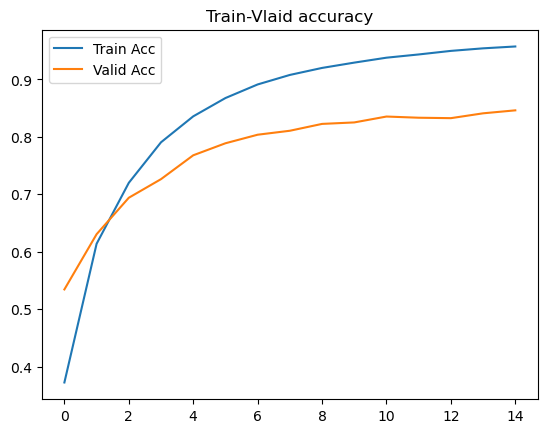

epoch 15 loss: 0.1123: 100%|████████████████| 6406/6406 [25:05<00:00,  4.26it/s]

train accuracy = 0.96028
[[2148   18   11 ...    0    0    0]
 [  13 2101   51 ...    0    0    0]
 [   8   75 2006 ...    0    0    0]
 ...
 [   0    0    0 ... 2165   22    0]
 [   0    0    0 ...   26 2147    0]
 [   0    0    0 ...    0    0 2189]]



epoch 15 loss: 0.5673: 100%|████████████████| 1750/1750 [02:59<00:00,  9.73it/s]


validation accuracy = 0.84724
[[273  13   4 ...   0   0   0]
 [  1 238  14 ...   0   1   0]
 [  3  53 379 ...   0   0   0]
 ...
 [  0   0   0 ... 169   9   0]
 [  0   0   0 ...  13 201   0]
 [  0   0   0 ...   0   0 218]]


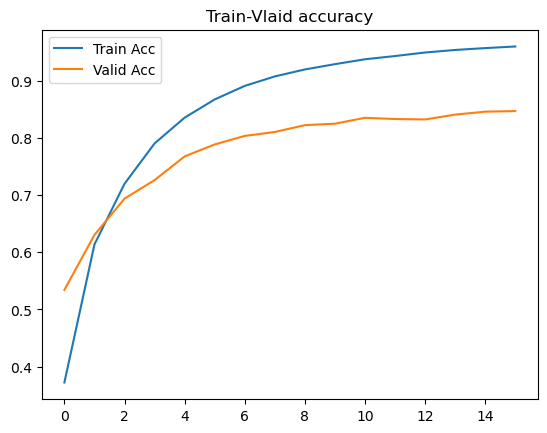

epoch 16 loss: 0.1053: 100%|████████████████| 6406/6406 [25:09<00:00,  4.24it/s]

train accuracy = 0.96315
[[2152    8   11 ...    0    0    0]
 [  10 2124   45 ...    0    0    0]
 [   6   53 2041 ...    0    0    0]
 ...
 [   0    0    0 ... 2156   18    0]
 [   0    0    0 ...   22 2151    0]
 [   0    0    0 ...    0    0 2189]]



epoch 16 loss: 0.5739: 100%|████████████████| 1750/1750 [03:01<00:00,  9.66it/s]


validation accuracy = 0.85038
[[284   7   1 ...   0   0   0]
 [  2 240   9 ...   0   1   0]
 [  5  56 368 ...   0   0   0]
 ...
 [  0   0   0 ... 162  15   0]
 [  0   0   0 ...  13 195   0]
 [  0   0   0 ...   0   1 216]]


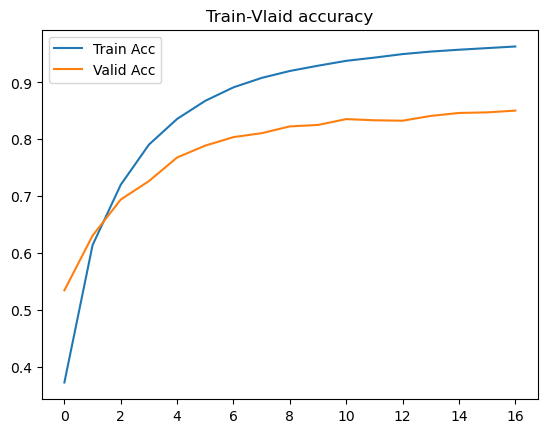

epoch 17 loss: 0.1107: 100%|████████████████| 6406/6406 [25:13<00:00,  4.23it/s]

train accuracy = 0.96483
[[2158    9    6 ...    0    0    0]
 [  10 2108   52 ...    0    0    0]
 [   3   67 2011 ...    0    1    0]
 ...
 [   0    0    0 ... 2164   22    0]
 [   0    0    1 ...   22 2143    0]
 [   0    0    0 ...    0    0 2194]]



epoch 17 loss: 0.5912: 100%|████████████████| 1750/1750 [03:08<00:00,  9.31it/s]


validation accuracy = 0.84906
[[284   9   1 ...   0   0   0]
 [  7 225  19 ...   0   2   0]
 [  3  39 409 ...   0   0   0]
 ...
 [  0   0   0 ... 174   6   0]
 [  0   0   0 ...  11 207   0]
 [  0   0   0 ...   0   0 216]]


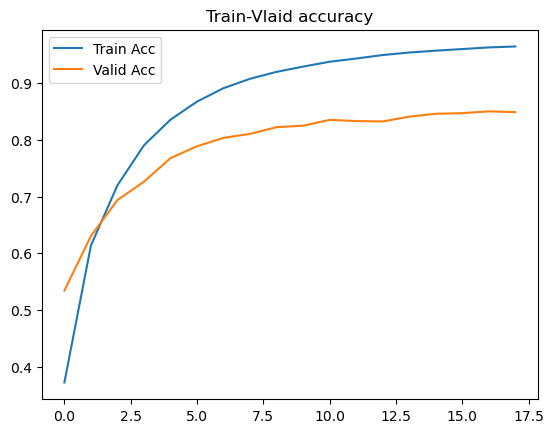

epoch 18 loss: 0.1107: 100%|████████████████| 6406/6406 [25:57<00:00,  4.11it/s]

train accuracy = 0.96744
[[2161   12    8 ...    0    0    0]
 [   8 2131   37 ...    0    0    0]
 [   3   51 2046 ...    0    0    0]
 ...
 [   0    0    0 ... 2163   20    0]
 [   0    0    0 ...   22 2153    0]
 [   0    0    0 ...    0    0 2191]]



epoch 18 loss: 0.6177: 100%|████████████████| 1750/1750 [03:05<00:00,  9.41it/s]


validation accuracy = 0.84670
[[283   9   2 ...   0   0   0]
 [  3 229  12 ...   0   2   0]
 [  4  43 386 ...   0   0   0]
 ...
 [  0   0   0 ... 168   8   0]
 [  0   0   0 ...  10 201   0]
 [  0   0   0 ...   0   0 218]]


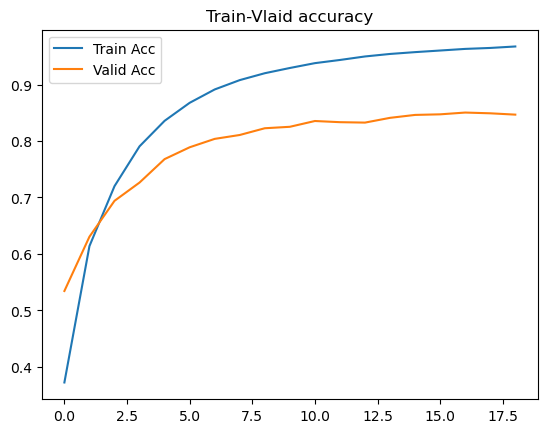

epoch 19 loss: 0.0858: 100%|████████████████| 6406/6406 [25:31<00:00,  4.18it/s]

train accuracy = 0.96938
[[2174    9    7 ...    0    0    0]
 [   5 2146   31 ...    0    0    0]
 [   7   51 2070 ...    0    0    0]
 ...
 [   0    0    0 ... 2166   23    0]
 [   0    0    0 ...   24 2150    0]
 [   0    0    0 ...    0    0 2192]]



epoch 19 loss: 0.5866: 100%|████████████████| 1750/1750 [03:05<00:00,  9.42it/s]


validation accuracy = 0.85449
[[288   4   2 ...   0   0   0]
 [  6 232  11 ...   0   1   0]
 [  1  53 387 ...   0   0   0]
 ...
 [  0   0   0 ... 172   2   0]
 [  0   0   0 ...  13 200   0]
 [  0   0   0 ...   0   0 215]]


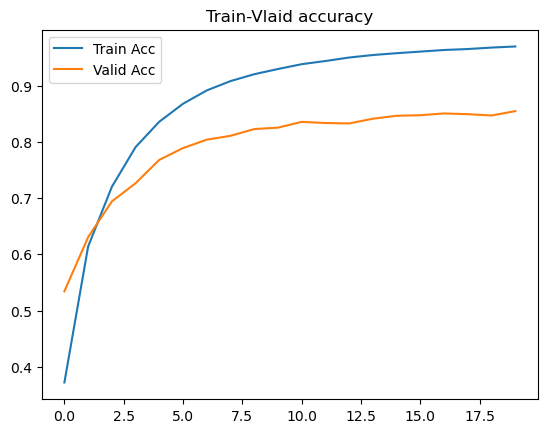

epoch 20 loss: 0.0845: 100%|████████████████| 6406/6406 [25:21<00:00,  4.21it/s]

train accuracy = 0.97095
[[2165    9    4 ...    0    0    1]
 [   7 2134   36 ...    0    0    0]
 [   9   44 2063 ...    0    0    0]
 ...
 [   0    0    0 ... 2159   17    0]
 [   0    0    0 ...   21 2153    0]
 [   0    0    0 ...    0    0 2191]]



epoch 20 loss: 0.6023: 100%|████████████████| 1750/1750 [03:06<00:00,  9.40it/s]


validation accuracy = 0.85135
[[275   8   1 ...   0   0   0]
 [  3 230  18 ...   0   1   0]
 [  1  44 405 ...   0   1   0]
 ...
 [  0   0   0 ... 170   2   0]
 [  0   0   0 ...  14 201   0]
 [  0   0   0 ...   0   0 218]]


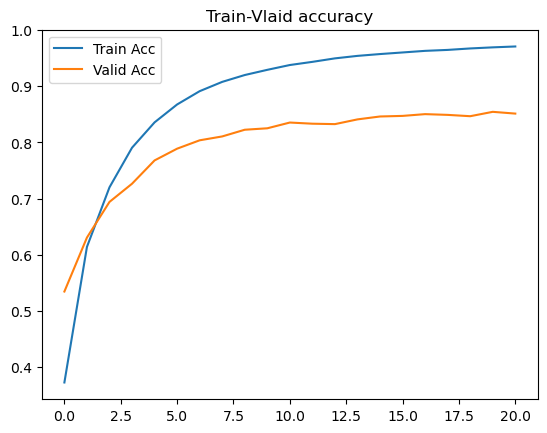

epoch 21 loss: 0.0928: 100%|████████████████| 6406/6406 [25:25<00:00,  4.20it/s]

train accuracy = 0.97337
[[2170    9    3 ...    0    0    0]
 [  14 2129   38 ...    0    0    0]
 [   5   49 2072 ...    0    0    0]
 ...
 [   0    0    0 ... 2166   17    0]
 [   0    0    0 ...   13 2166    0]
 [   0    0    0 ...    0    0 2194]]



epoch 21 loss: 0.5842: 100%|████████████████| 1750/1750 [03:05<00:00,  9.43it/s]


validation accuracy = 0.85767
[[282   7   2 ...   0   0   0]
 [  7 228  15 ...   0   2   0]
 [  2  38 408 ...   0   0   0]
 ...
 [  0   0   0 ... 169   5   0]
 [  0   0   0 ...  16 196   0]
 [  0   0   0 ...   0   0 215]]


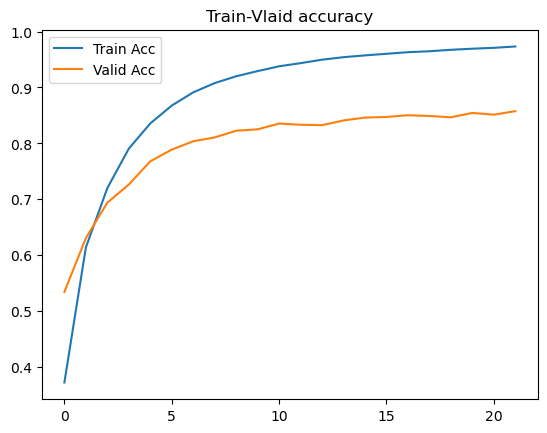

epoch 22 loss: 0.0768: 100%|████████████████| 6406/6406 [25:22<00:00,  4.21it/s]

train accuracy = 0.97342
[[2165    9    5 ...    0    0    0]
 [   7 2142   25 ...    0    0    1]
 [   7   29 2091 ...    0    0    0]
 ...
 [   0    0    0 ... 2169   15    0]
 [   0    0    0 ...   10 2166    0]
 [   0    0    0 ...    0    0 2192]]



epoch 22 loss: 0.5844: 100%|████████████████| 1750/1750 [03:06<00:00,  9.38it/s]


validation accuracy = 0.85782
[[289   5   1 ...   0   0   0]
 [  4 237  10 ...   0   2   0]
 [  4  51 399 ...   0   0   0]
 ...
 [  0   0   0 ... 173   8   0]
 [  0   0   0 ...  11 211   0]
 [  0   0   0 ...   0   0 218]]


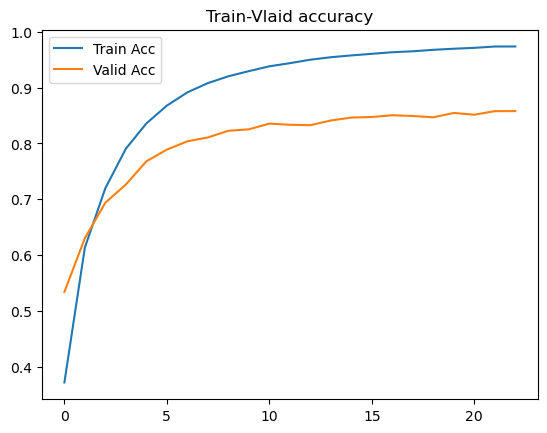

epoch 23 loss: 0.0733: 100%|████████████████| 6406/6406 [25:25<00:00,  4.20it/s]

train accuracy = 0.97564
[[2171    7    2 ...    0    0    0]
 [  10 2145   26 ...    0    0    0]
 [   4   28 2097 ...    0    0    0]
 ...
 [   0    0    1 ... 2169   17    1]
 [   0    0    0 ...   18 2164    0]
 [   0    0    0 ...    0    0 2193]]



epoch 23 loss: 0.6075: 100%|████████████████| 1750/1750 [03:07<00:00,  9.35it/s]


validation accuracy = 0.86132
[[289   5   2 ...   0   0   0]
 [  5 234  12 ...   0   2   0]
 [  1  50 411 ...   0   0   0]
 ...
 [  0   0   0 ... 172   5   0]
 [  0   0   0 ...  10 204   0]
 [  0   0   0 ...   0   0 215]]


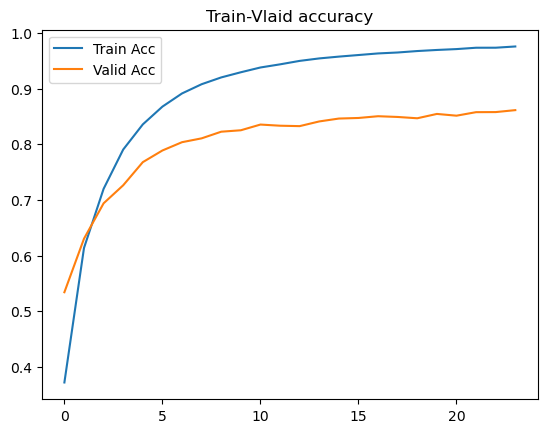

epoch 24 loss: 0.0671: 100%|████████████████| 6406/6406 [25:20<00:00,  4.21it/s]

train accuracy = 0.97660
[[2175    5    2 ...    0    0    0]
 [   7 2160   25 ...    0    0    0]
 [   4   31 2092 ...    0    0    0]
 ...
 [   0    0    0 ... 2174    9    0]
 [   0    0    0 ...   16 2173    0]
 [   0    0    0 ...    0    0 2191]]



epoch 24 loss: 0.6146: 100%|████████████████| 1750/1750 [03:06<00:00,  9.36it/s]


validation accuracy = 0.86082
[[288   4   5 ...   0   0   0]
 [  4 235  17 ...   0   1   0]
 [  0  54 409 ...   0   0   0]
 ...
 [  0   0   0 ... 161   9   0]
 [  0   0   0 ...   8 207   0]
 [  0   0   0 ...   0   0 218]]


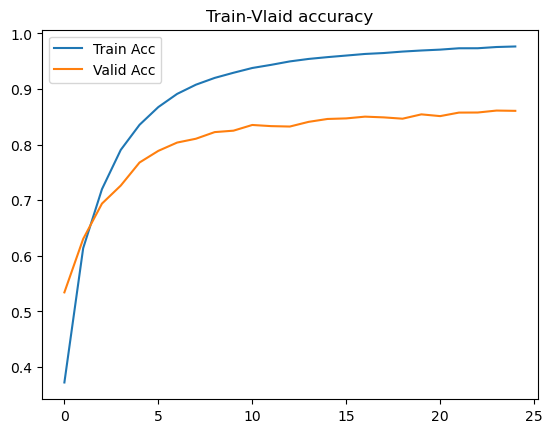

epoch 25 loss: 0.0437: 100%|████████████████| 6406/6406 [25:24<00:00,  4.20it/s]

train accuracy = 0.98475
[[2193    1    5 ...    0    0    0]
 [   3 2168   18 ...    0    0    0]
 [   4   22 2129 ...    0    0    0]
 ...
 [   0    0    0 ... 2186   10    0]
 [   0    0    0 ...    2 2190    0]
 [   0    0    0 ...    0    0 2196]]



epoch 25 loss: 0.5718: 100%|████████████████| 1750/1750 [03:07<00:00,  9.32it/s]


validation accuracy = 0.87286
[[295   1   3 ...   0   0   0]
 [  3 238  17 ...   0   2   0]
 [  0  35 433 ...   0   0   0]
 ...
 [  0   0   0 ... 170   4   0]
 [  0   0   0 ...   9 197   0]
 [  0   0   0 ...   0   0 221]]


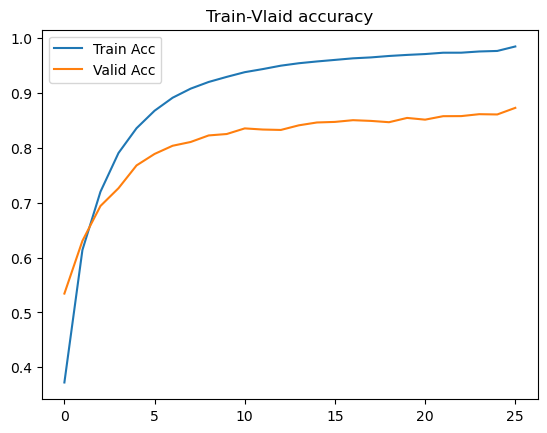

epoch 26 loss: 0.0394: 100%|████████████████| 6406/6406 [25:24<00:00,  4.20it/s]

train accuracy = 0.98755
[[2194    3    1 ...    0    0    0]
 [   3 2180   13 ...    0    0    0]
 [   0   19 2154 ...    0    0    0]
 ...
 [   0    0    0 ... 2190    9    0]
 [   0    0    0 ...   10 2185    0]
 [   0    0    0 ...    0    0 2202]]



epoch 26 loss: 0.5838: 100%|████████████████| 1750/1750 [03:07<00:00,  9.34it/s]


validation accuracy = 0.87375
[[286   6   0 ...   0   0   0]
 [  2 237  16 ...   0   2   0]
 [  1  43 412 ...   0   0   0]
 ...
 [  0   0   0 ... 175   5   0]
 [  0   0   0 ...  13 198   0]
 [  0   0   0 ...   0   0 219]]


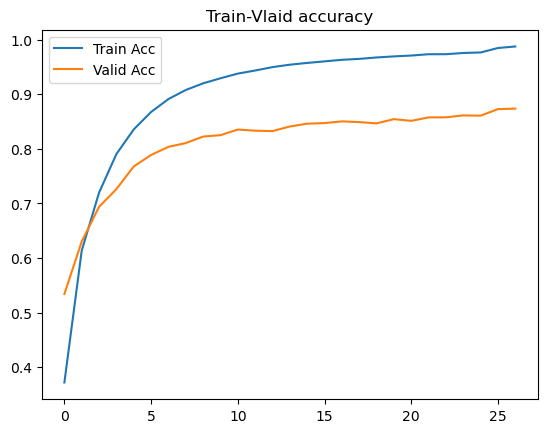

epoch 27 loss: 0.0344: 100%|████████████████| 6406/6406 [25:24<00:00,  4.20it/s]

train accuracy = 0.98849
[[2190    4    0 ...    0    0    0]
 [   2 2177   16 ...    0    0    0]
 [   0   26 2146 ...    0    0    0]
 ...
 [   0    0    0 ... 2192    7    0]
 [   0    0    0 ...    7 2185    0]
 [   0    0    0 ...    0    0 2202]]



epoch 27 loss: 0.5886: 100%|████████████████| 1750/1750 [03:08<00:00,  9.30it/s]


validation accuracy = 0.87393
[[293   1   2 ...   0   0   0]
 [  2 228  19 ...   0   2   0]
 [  1  36 425 ...   0   0   0]
 ...
 [  0   0   0 ... 175   5   0]
 [  0   0   0 ...  12 203   0]
 [  0   0   0 ...   0   0 218]]


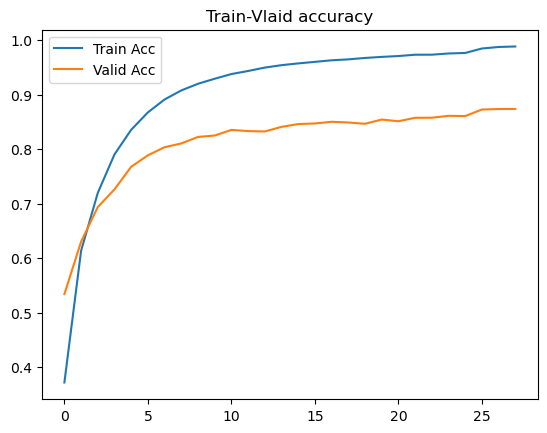

epoch 28 loss: 0.0282: 100%|████████████████| 6406/6406 [25:23<00:00,  4.21it/s]

train accuracy = 0.98943
[[2192    6    3 ...    0    0    0]
 [   4 2174   17 ...    0    0    0]
 [   2   25 2139 ...    0    0    0]
 ...
 [   0    0    0 ... 2190   10    0]
 [   0    0    0 ...   11 2184    0]
 [   0    0    0 ...    0    0 2202]]



epoch 28 loss: 0.5940: 100%|████████████████| 1750/1750 [03:06<00:00,  9.37it/s]


validation accuracy = 0.87568
[[282   8   3 ...   0   0   0]
 [  2 240  15 ...   0   2   0]
 [  2  44 419 ...   0   0   0]
 ...
 [  0   0   0 ... 174   6   0]
 [  0   0   0 ...  12 206   0]
 [  0   0   0 ...   0   0 219]]


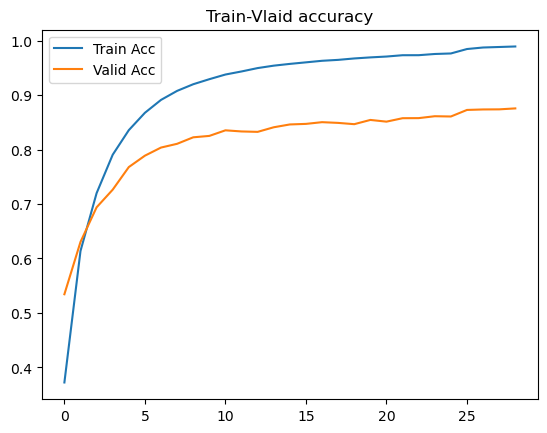

epoch 29 loss: 0.0386: 100%|████████████████| 6406/6406 [25:25<00:00,  4.20it/s]

train accuracy = 0.98944
[[2188    3    3 ...    0    0    0]
 [   4 2184   12 ...    0    0    0]
 [   4   17 2157 ...    0    0    0]
 ...
 [   0    0    0 ... 2191    9    0]
 [   0    0    0 ...   10 2184    0]
 [   0    0    0 ...    0    0 2201]]



epoch 29 loss: 0.5914: 100%|████████████████| 1750/1750 [03:07<00:00,  9.34it/s]


validation accuracy = 0.87643
[[294   3   0 ...   0   0   0]
 [  2 232  20 ...   0   2   0]
 [  3  43 431 ...   0   0   0]
 ...
 [  0   0   0 ... 174   5   0]
 [  0   0   0 ...  13 204   0]
 [  0   0   0 ...   0   0 216]]


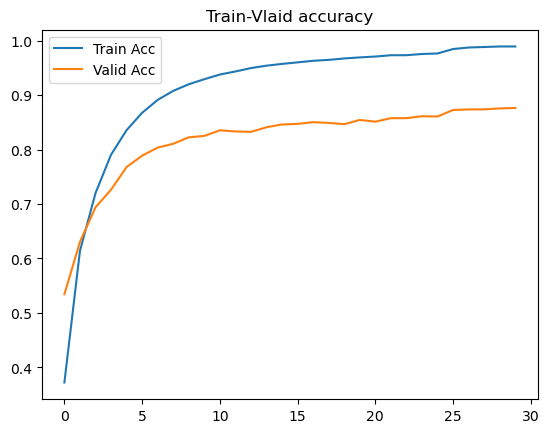

epoch 30 loss: 0.0341: 100%|████████████████| 6406/6406 [25:31<00:00,  4.18it/s]

train accuracy = 0.99014
[[2188    5    3 ...    0    0    0]
 [   4 2175   13 ...    0    0    0]
 [   1   20 2159 ...    0    0    0]
 ...
 [   0    0    0 ... 2190   11    0]
 [   0    0    0 ...    9 2186    0]
 [   0    0    0 ...    0    0 2197]]



epoch 30 loss: 0.6150: 100%|████████████████| 1750/1750 [03:08<00:00,  9.30it/s]


validation accuracy = 0.87368
[[289   5   2 ...   0   0   0]
 [  2 226  25 ...   0   2   0]
 [  0  37 430 ...   0   0   0]
 ...
 [  0   0   0 ... 165  10   0]
 [  0   0   0 ...  10 210   0]
 [  0   0   0 ...   0   0 217]]


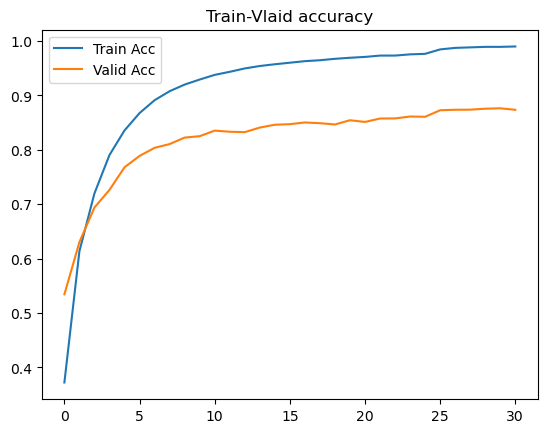

epoch 31 loss: 0.0295: 100%|████████████████| 6406/6406 [25:29<00:00,  4.19it/s]

train accuracy = 0.99059
[[2192    1    2 ...    0    0    0]
 [   1 2186   13 ...    0    0    0]
 [   0   12 2166 ...    0    0    0]
 ...
 [   0    0    0 ... 2199    3    0]
 [   0    0    0 ...    4 2194    0]
 [   0    0    0 ...    0    0 2200]]



epoch 31 loss: 0.5923: 100%|████████████████| 1750/1750 [03:06<00:00,  9.37it/s]


validation accuracy = 0.87672
[[294   0   1 ...   0   0   0]
 [  4 227  26 ...   0   2   0]
 [  1  35 439 ...   0   0   0]
 ...
 [  0   0   0 ... 172   8   0]
 [  0   0   0 ...  13 203   0]
 [  0   0   0 ...   0   0 216]]


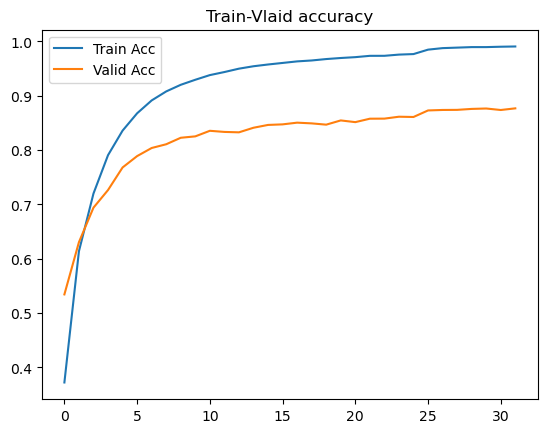

epoch 32 loss: 0.0262: 100%|████████████████| 6406/6406 [25:30<00:00,  4.18it/s]

train accuracy = 0.99089
[[2197    0    3 ...    0    0    0]
 [   3 2174   15 ...    0    0    0]
 [   2   14 2161 ...    0    0    0]
 ...
 [   0    0    0 ... 2196    5    0]
 [   0    0    0 ...    6 2190    0]
 [   0    0    0 ...    0    0 2199]]



epoch 32 loss: 0.6167: 100%|████████████████| 1750/1750 [03:07<00:00,  9.35it/s]


validation accuracy = 0.87418
[[293   2   1 ...   0   0   0]
 [  3 237  13 ...   0   2   0]
 [  0  50 428 ...   0   0   0]
 ...
 [  0   0   0 ... 169   8   0]
 [  0   0   0 ...   9 209   0]
 [  0   0   0 ...   0   0 218]]


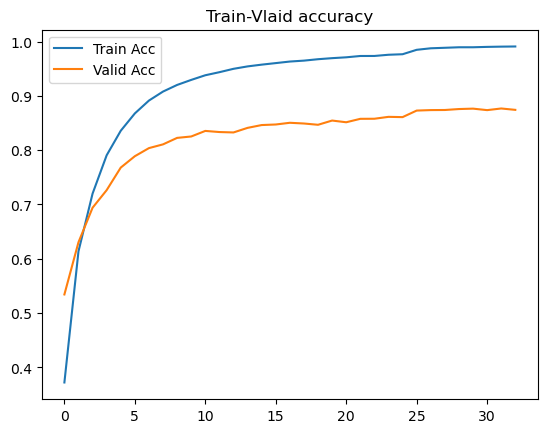

epoch 33 loss: 0.0256: 100%|████████████████| 6406/6406 [25:33<00:00,  4.18it/s]

train accuracy = 0.99123
[[2196    1    0 ...    0    0    0]
 [   4 2187    7 ...    0    0    0]
 [   2   12 2158 ...    0    0    0]
 ...
 [   0    0    0 ... 2192    8    0]
 [   0    0    0 ...   11 2182    0]
 [   0    0    0 ...    0    0 2202]]



epoch 33 loss: 0.5964: 100%|████████████████| 1750/1750 [03:08<00:00,  9.28it/s]


validation accuracy = 0.87804
[[289   3   2 ...   0   0   0]
 [  3 242   8 ...   0   2   0]
 [  0  47 416 ...   0   0   0]
 ...
 [  0   0   0 ... 173   3   0]
 [  0   0   0 ...  14 201   0]
 [  0   0   0 ...   0   0 220]]


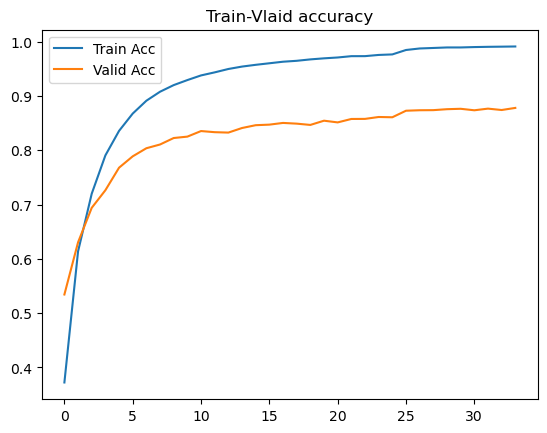

epoch 34 loss: 0.0242: 100%|████████████████| 6406/6406 [25:32<00:00,  4.18it/s]

train accuracy = 0.99125
[[2192    3    0 ...    0    0    0]
 [   1 2186   13 ...    0    0    0]
 [   2   15 2163 ...    0    0    0]
 ...
 [   0    0    0 ... 2193    2    0]
 [   0    0    0 ...    4 2196    0]
 [   0    0    0 ...    0    0 2199]]



epoch 34 loss: 0.5825: 100%|████████████████| 1750/1750 [03:07<00:00,  9.33it/s]


validation accuracy = 0.87994
[[293   1   2 ...   0   0   0]
 [  4 229  24 ...   0   2   0]
 [  0  37 439 ...   0   0   0]
 ...
 [  0   0   0 ... 169  10   0]
 [  0   0   0 ...   9 209   0]
 [  0   0   0 ...   0   0 220]]


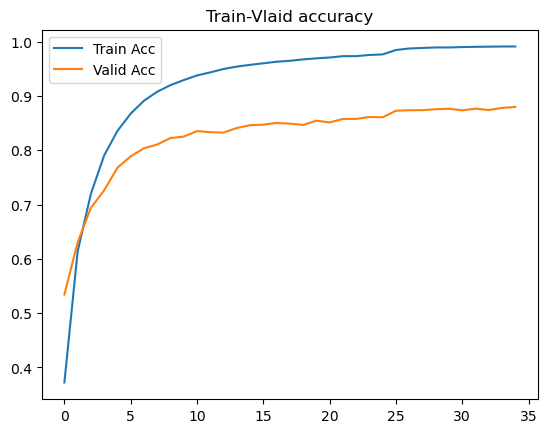

epoch 35 loss: 0.0201: 100%|████████████████| 6406/6406 [25:37<00:00,  4.17it/s]

train accuracy = 0.99188
[[2194    3    1 ...    0    0    0]
 [   1 2190    6 ...    0    0    0]
 [   1   10 2164 ...    0    0    0]
 ...
 [   0    0    0 ... 2193    7    0]
 [   0    0    0 ...    9 2188    0]
 [   0    0    0 ...    0    0 2202]]



epoch 35 loss: 0.6150: 100%|████████████████| 1750/1750 [03:07<00:00,  9.34it/s]


validation accuracy = 0.87783
[[291   3   2 ...   0   0   0]
 [  1 244  11 ...   0   2   0]
 [  1  49 404 ...   0   0   0]
 ...
 [  0   0   0 ... 171   8   0]
 [  0   0   0 ...  12 207   0]
 [  0   0   0 ...   0   0 219]]


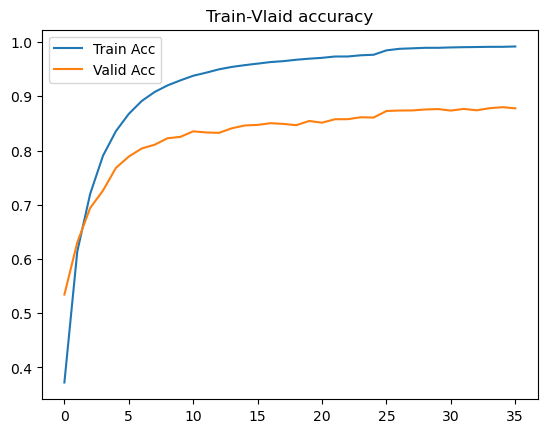

epoch 36 loss: 0.0241: 100%|████████████████| 6406/6406 [25:38<00:00,  4.17it/s]

train accuracy = 0.99143
[[2197    2    0 ...    0    0    0]
 [   4 2185   10 ...    0    0    0]
 [   1   17 2157 ...    0    0    0]
 ...
 [   0    0    0 ... 2195    5    0]
 [   0    0    0 ...    6 2188    0]
 [   0    0    0 ...    0    0 2201]]



epoch 36 loss: 0.6335: 100%|████████████████| 1750/1750 [03:07<00:00,  9.31it/s]


validation accuracy = 0.87686
[[290   2   3 ...   0   0   0]
 [  1 242  17 ...   0   2   0]
 [  0  44 417 ...   0   0   0]
 ...
 [  0   0   0 ... 170   5   0]
 [  0   0   0 ...  12 204   0]
 [  0   0   0 ...   0   0 217]]


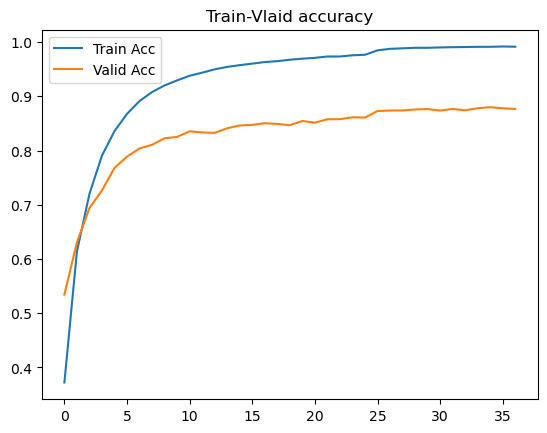

epoch 37 loss: 0.0320: 100%|████████████████| 6406/6406 [25:35<00:00,  4.17it/s]

train accuracy = 0.99217
[[2196    1    0 ...    0    0    0]
 [   1 2190    9 ...    0    0    0]
 [   0    7 2178 ...    0    0    0]
 ...
 [   0    0    0 ... 2199    2    0]
 [   0    0    0 ...    2 2191    0]
 [   0    0    0 ...    0    0 2201]]



epoch 37 loss: 0.6423: 100%|████████████████| 1750/1750 [03:08<00:00,  9.28it/s]


validation accuracy = 0.87665
[[289   3   3 ...   0   0   0]
 [  2 235  18 ...   0   2   0]
 [  2  39 429 ...   0   0   0]
 ...
 [  0   0   0 ... 174   3   0]
 [  0   0   0 ...  14 202   0]
 [  0   0   0 ...   0   0 219]]


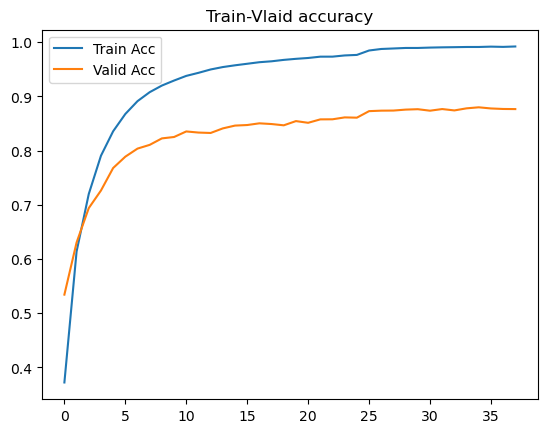

epoch 38 loss: 0.0285: 100%|████████████████| 6406/6406 [25:35<00:00,  4.17it/s]

train accuracy = 0.99276
[[2189    4    2 ...    0    0    0]
 [   0 2194    6 ...    0    0    0]
 [   2    8 2168 ...    0    0    0]
 ...
 [   0    0    0 ... 2197    5    0]
 [   0    0    0 ...    9 2189    0]
 [   0    0    0 ...    0    0 2202]]



epoch 38 loss: 0.6247: 100%|████████████████| 1750/1750 [03:07<00:00,  9.36it/s]


validation accuracy = 0.88065
[[283   4   3 ...   0   0   0]
 [  3 232  23 ...   0   2   0]
 [  0  34 427 ...   0   0   0]
 ...
 [  0   0   0 ... 171  10   0]
 [  0   0   0 ...   7 212   0]
 [  0   0   0 ...   0   0 219]]


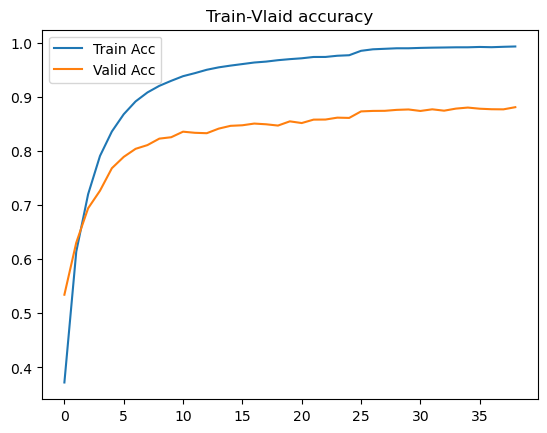

epoch 39 loss: 0.0213: 100%|████████████████| 6406/6406 [25:44<00:00,  4.15it/s]

train accuracy = 0.99244
[[2190    3    2 ...    0    0    0]
 [   3 2189    8 ...    0    0    0]
 [   3    8 2171 ...    0    0    0]
 ...
 [   0    0    0 ... 2195    4    0]
 [   0    0    0 ...    5 2191    0]
 [   0    0    0 ...    0    0 2199]]



epoch 39 loss: 0.6127: 100%|████████████████| 1750/1750 [03:06<00:00,  9.39it/s]


validation accuracy = 0.87840
[[285   5   3 ...   0   0   0]
 [  2 238  12 ...   0   2   0]
 [  2  45 417 ...   0   0   0]
 ...
 [  0   0   0 ... 171   3   0]
 [  0   0   0 ...  10 204   0]
 [  0   0   0 ...   0   0 219]]


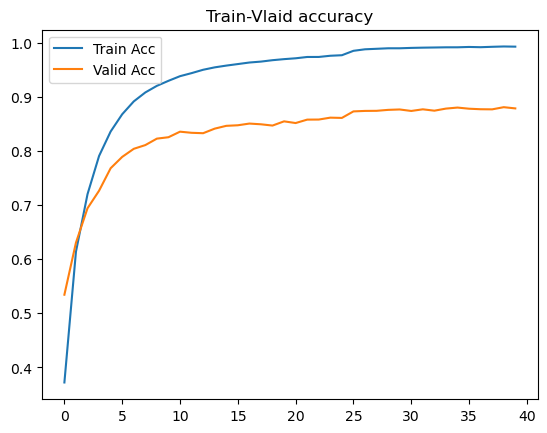

time : 18:55:14
Best Epoch : 38/ 40
Best Train Accuracy : 0.99276
[[2189    4    2 ...    0    0    0]
 [   0 2194    6 ...    0    0    0]
 [   2    8 2168 ...    0    0    0]
 ...
 [   0    0    0 ... 2197    5    0]
 [   0    0    0 ...    9 2189    0]
 [   0    0    0 ...    0    0 2202]]
Best Valid Accuracy : 0.88065
[[283   4   3 ...   0   0   0]
 [  3 232  23 ...   0   2   0]
 [  0  34 427 ...   0   0   0]
 ...
 [  0   0   0 ... 171  10   0]
 [  0   0   0 ...   7 212   0]
 [  0   0   0 ...   0   0 219]]


AttributeError: 'DataParallel' object has no attribute 'cnn_model'

AttributeError: 'DataParallel' object has no attribute 'cnn_model'

In [11]:
%run classification_train_efficientnet2.ipynb

In [18]:
print(f'Best Epoch : {best_index}/ {len(valid_acc_list)}')
print(f'Best Train Accuracy : {train_acc_list[best_index]:.5f}')
print(train_matrix_list[best_index])
print(f'Best Valid Accuracy : {valid_acc_list[best_index]:.5f}')
print(valid_matrix_list[best_index])

Best Epoch : 38/ 40
Best Train Accuracy : 0.99712
[[2847    3    1 ...    0    0    0]
 [   4 2849    0 ...    0    0    0]
 [   3    1 2843 ...    0    0    0]
 ...
 [   0    0    0 ... 2848    3    0]
 [   0    0    0 ...    2 2849    0]
 [   0    0    0 ...    0    0 2852]]
Best Valid Accuracy : 0.88483
[[255  10   2 ...   0   0   0]
 [  6 196   0 ...   0   0   0]
 [  3   0 389 ...   0   0   0]
 ...
 [  0   0   0 ... 178   5   0]
 [  0   0   0 ...  12 208   0]
 [  0   0   0 ...   0   0 218]]


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: honbul. Use `wandb login --relogin` to force relogin


/home/super/endo_venv/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(
epoch 0 loss: 0.0238: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:26<00:00,  4.79it/s]


train accuracy = 0.98053
[[14778   222]
 [  362 14638]]


epoch 0 loss: 0.5145: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 20.92it/s]


validation accuracy = 0.81408
[[512 127]
 [  5  66]]


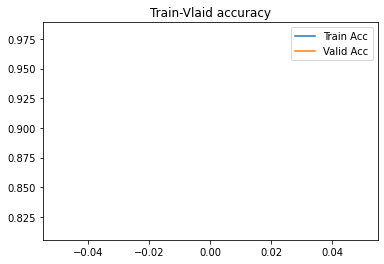

epoch 1 loss: 0.0124: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:25<00:00,  4.79it/s]


train accuracy = 0.99637
[[14946    54]
 [   55 14945]]


epoch 1 loss: 0.7367: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.10it/s]


validation accuracy = 0.70704
[[431 208]
 [  0  71]]


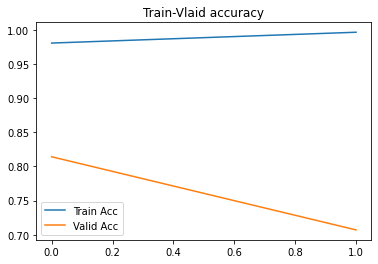

epoch 2 loss: 0.0020: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:30<00:00,  4.76it/s]


train accuracy = 0.99767
[[14959    41]
 [   29 14971]]


epoch 2 loss: 0.6676: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.18it/s]


validation accuracy = 0.80563
[[509 130]
 [  8  63]]


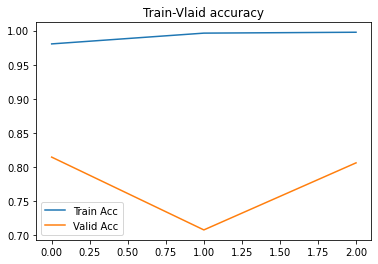

epoch 3 loss: 0.0028: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:31<00:00,  4.75it/s]


train accuracy = 0.99870
[[14980    20]
 [   19 14981]]


epoch 3 loss: 0.3945: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 20.96it/s]


validation accuracy = 0.85915
[[546  93]
 [  7  64]]


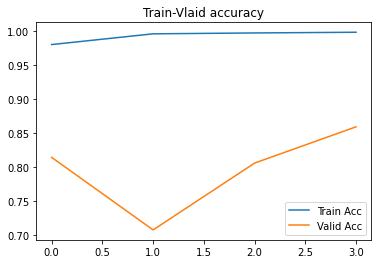

epoch 4 loss: 0.0052: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:32<00:00,  4.74it/s]


train accuracy = 0.99773
[[14961    39]
 [   29 14971]]


epoch 4 loss: 0.3124: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.07it/s]


validation accuracy = 0.88169
[[569  70]
 [ 14  57]]


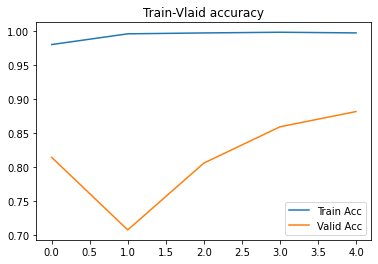

epoch 5 loss: 0.0049:  47%|██████████████████████████▊                              | 1413/3000 [04:58<05:23,  4.90it/s]

In [ ]:
%run classification_train_val_separate_efficientnet.ipynb